<a href="https://colab.research.google.com/github/Marianna-Pinho/Machine-Learning-Classes/blob/master/01_Trabalho_Final_ML_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - Aprendizado de Máquina

**Aluno(a):** Marianna de Pinho Severo 

**Matrícula:** 374856 

**Professor(a):** Regis Pires

## 1) Problema a ser resolvido

### Descrição
O problema a ser resolvido consiste na identificação de doenças respiratórios em pessoas
através da análise de áudios que registram sua respiração. De acordo com [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database), o som que é
emitido quando uma pessoa respira está diretamente relacionado com o movimento do ar,
as condições do tecido pulmonar e a existência ou não de secreções dentro do pulmão.

Vamos utilizar o dataset para um problema de classificação, que consiste em, dado um
conjunto de áudios que capturam a respiração de um certo indivíduo, determinar se ele
possui, ou não, uma das doenças respiratórias cobertas pelo dataset. Mais especificamente, diremos se um paciente é saudável ou se possui alguma doença respiratória.

### Datasets a serem utilizados
Utilizaremos o dataset criado para a International Conference on Biomedical
Health Informatics - ICBHI 2017, disponível em [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database). Ele foi criado por duas equipes, sendo
uma de Portugal e outra da Grécia. Esse dataset inclui 920 anotações de áudios, de
tamanhos variáveis entre 10s e 90s. Essas gravações foram obtidas a partir de 126
pacientes diferentes, contendo 6898 ciclos respiratórios, dos quais 1864 contêm
crepitações, 886 contêm chiados e 506 contêm tanto crepitações quanto chiados. Além disso,
o dataset é composto tanto por áudios limpos como por áudios com ruídos. E existem
pacientes de todas as faixas etárias: crianças, adultos e idosos.

### Features
#### a) Pacientes:
**Dados demográficos:** número do paciente, idade, sexo, IMC do adulto
(kg/m2), peso da criança (kg), altura da criança (cm).

#### b) Áudios:
**numero do paciente**<br>
**Índice de gravação**<br>
**Localização no peito:** trachea (Tc), anterior left (Al), anterior right (Ar),
posterior left (Pl), posterior right (Pr), lateral left (Ll), lateral right (Lr).<br>
**Modo de aquisição:** sequential/single channel (sc),
simultaneous/multichannel (mc).<br>
**Equipamento de gravação:** AKG C417L Microphone (AKGC417L), 3M
Littmann Classic II SE Stethoscope (LittC2SE), 3M Litmmann 3200 Electronic
Stethoscope (Litt3200), WelchAllyn Meditron Master Elite Electronic
Stethoscope (Meditron).

#### c) Anotações:
Início do ciclo respiratório(s), Fim do ciclo respiratório(s), Presença/Ausência
de crepitações (presence=1, absence=0), Presença/Ausência de sibilos
(presence=1, absence=0).

**Este trabalho utiliza trechos de código disponibilizados em:** 

[Classificação Áudio](https://github.com/seth814/Audio-Classification/blob/master/eda.py)

[Classification of Music into different Genres using Keras](https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0)

**Função auxiliar para plotagem dos sinais**

In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

## 2) Importando Bibliotecas

In [ ]:
%matplotlib inline
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import librosa.display

## 3) Preparando conjunto de dados

### Passo 01: Criar *filenames*

Os nomes dos arquivos de áudio são compostos pelo número do paciente, índice de gravação, localização do microfone no peito do paciente, modo de aquisição do áudio e equipamento de gravação. Essas informações podem ser vistas em **filenames**.

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = PATH) if '.txt' in s]
filenames[:5]

['107_2b4_Pr_mc_AKGC417L',
 '179_1b1_Tc_sc_Meditron',
 '218_1p1_Pr_sc_Litt3200',
 '222_1b1_Pr_sc_Meditron',
 '198_6p1_Ll_mc_AKGC417L']

### Passo 02: Ler *labels*

As *labels* do conjunto de dados consistem nos diagnósticos dos pacientes. Elas estão no arquivo **patient_diagnosis.csv**, juntamente com o número do paciente a quem o diagnóstico pertence.

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/dataset/patient_diagnosis.csv'
classes = pd.read_csv(PATH, names = ['patient_number','diagnosis'])
classes.head()

,patient_number,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


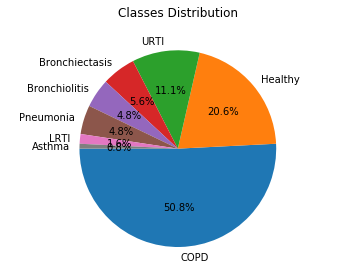

In [ ]:
classes_dist = classes['diagnosis'].value_counts()
fig, ax = plt.subplots()
ax.set_title('Classes Distribution', y=1.08)
ax.pie(classes_dist, labels=classes_dist.index, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show()

### Passo 03: Transformar *labels* de valor categórico para numérico

Esse conjunto de dados possui uma *label* para cada tipo de problema respiratório que um paciente possui. Entretanto, não queremos determinar o tipo de problema respiratório, mas apenas se o paciente possui ou não algum deles. Dessa forma, mapearemos as *labels* em que o paciente é saudável para 1 (*Healthy*) e o restante para -1.

In [ ]:
classes['diagnosis'] = np.where(classes['diagnosis'] == 'Healthy', 1, -1)
classes.head()

,patient_number,diagnosis
0,101,-1
1,102,1
2,103,-1
3,104,-1
4,105,-1


### Passo 04: Observar distribuição dos dados

É possível observarmos que a quantidade de pacientes com algum problema respiratório (-1) é maior do que a de pacientes saudáveis (1).

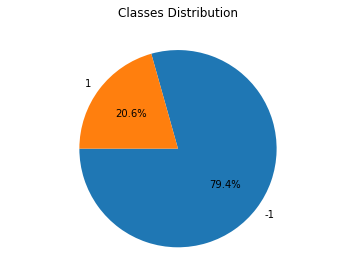

In [ ]:
classes_dist = classes['diagnosis'].value_counts()
fig, ax = plt.subplots()
ax.set_title('Classes Distribution', y=1.08)
ax.pie(classes_dist, labels=classes_dist.index, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show()

### Passo 05: Redistribuir os dados

Tentaremos pegar uma quantidade igual de pacientes saudáveis e não saudáveis do conjunto de dados.

In [ ]:
classes['diagnosis'].value_counts()

-1    100
 1     26
Name: diagnosis, dtype: int64

In [ ]:
#Pegamos a quantidade de pacientes saudáveis
amount_h = classes['diagnosis'].value_counts()[1]

In [ ]:
#Separamos pacientes saudáveis e não saudáveis
healthy_pacients = classes[classes['diagnosis'] == 1]
unhealthy_pacients = classes[classes['diagnosis'] == -1]

In [ ]:
healthy_pacients.shape, unhealthy_pacients.shape

((26, 2), (100, 2))

In [ ]:
#Pegamos apenas os amount_h primeiros pacientes não saudáveis

unhealthy_pacients = unhealthy_pacients.head(amount_h)
unhealthy_pacients.head()

,patient_number,diagnosis
0,101,-1
2,103,-1
3,104,-1
4,105,-1
5,106,-1


In [ ]:
patients = pd.concat([healthy_pacients, unhealthy_pacients], join="inner").sort_values(by='patient_number')
patients.head()

,patient_number,diagnosis
0,101,-1
1,102,1
2,103,-1
3,104,-1
4,105,-1


In [ ]:
patients['diagnosis'].value_counts()

 1    26
-1    26
Name: diagnosis, dtype: int64

### Passo 06: Ler arquivos de áudio

Leremos apenas os arquivos de áudio dos pacientes que selecionamos no passo anterior.

In [ ]:
#Essa função retorna os valores numéricos do áudio, a taxa de amostragem e a duração em segundos
def getAudioInfo(audio):
    signal, rate = librosa.load(audio)
    duration = [signal.shape[0]/rate]
    return signal, rate, duration

In [ ]:
dict_audio_signals = {}
dict_audio_rates = {}
dict_audio_durations = {}
dict_filename_label = {}

In [ ]:
# Ela também cria um dicionário que mapeia o nome do áudio com a label do paciente a quem ele pertence

PATH='/content/drive/My Drive/Colab Notebooks/audio_and_txt_files/'

for f in tqdm(filenames):
    number = f.split('_')[0]
   
    if(int(number) in patients['patient_number'].values):
      dict_audio_signals[f], dict_audio_rates[f], dict_audio_durations[f] = getAudioInfo(PATH + f + '.wav')
      dict_filename_label[f] = patients[patients['patient_number'] == int(number)].values[0,1]
      patients = patients[patients['patient_number'].values != int(number)]

100%|██████████| 920/920 [01:03<00:00, 14.46it/s]


In [ ]:
#for key in dict_filename_label:
 # print("Key:{} L:{}".format(key, dict_filename_label[key]))

In [ ]:
i = 0
j = 0
for key in dict_filename_label:
  if dict_filename_label[key] == 1:
    i+=1
  else:
    j+=1

print(i,j)

26 26


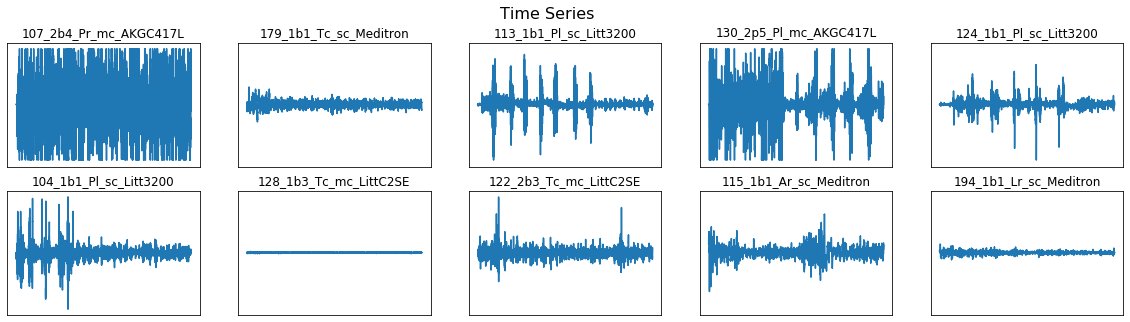

In [ ]:
plot_signals(dict_audio_signals)

### Passo 08: Criar conjunto de dados com as *features* extraídas

Neste passo, extrairemos as *features* de cada áudio e as salvaremos em um arquivo .csv.

As *features* a serem extraídas são a **stft**, o **rmse**, o **centroid spectral**, o **rolloff**, a **taxa de zero crossing** e o **mfcc**.

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/Colab Notebooks/datafinal.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for key in tqdm(dict_audio_signals):
  chroma_stft = librosa.amplitude_to_db(np.abs(librosa.stft(y=dict_audio_signals[key])))
  rmse = librosa.feature.rmse(y=dict_audio_signals[key])
  spec_cent = librosa.feature.spectral_centroid(y=dict_audio_signals[key], sr=dict_audio_rates[key])
  spec_bw = librosa.feature.spectral_bandwidth(y=dict_audio_signals[key], sr=dict_audio_rates[key])
  rolloff = librosa.feature.spectral_rolloff(y=dict_audio_signals[key], sr=dict_audio_rates[key])
  zcr = librosa.feature.zero_crossing_rate(dict_audio_signals[key])
  mfcc = librosa.feature.mfcc(y=dict_audio_signals[key], sr=dict_audio_rates[key])
  
  to_append = f'{key} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
  
  for e in mfcc:
    to_append += f' {np.mean(e)}'
    
  to_append += f' {dict_filename_label[key]}'
  file = open('/content/drive/My Drive/Colab Notebooks/datafinal.csv', 'a', newline='')
  with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())

100%|██████████| 52/52 [00:18<00:00,  3.10it/s]


# Breve análise dos dados

### Passo 01: Ler conjunto de dados

Agora, leremos as informações sobre os áudios, que estão salvas no arquivo **datafinal.csv**. Esse arquivo contém as *features* e os *labels* do conjunto de dados considerado.

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datafinal.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,107_2b4_Pr_mc_AKGC417L,-17.938953,0.412915,433.436041,1348.680562,352.475053,0.005968,-243.142066,135.449303,61.997014,45.659463,22.972295,18.716659,9.678623,10.696918,7.425557,10.237305,7.522652,9.883407,6.117369,7.523315,4.129134,5.851761,3.073761,4.703141,2.076042,3.625250,-1
1,179_1b1_Tc_sc_Meditron,-31.814646,0.051774,883.186376,2413.645032,1062.383792,0.010107,-498.754147,76.143643,55.564120,3.099266,32.182653,20.346869,25.803801,8.482742,18.637764,14.141950,17.027479,8.632240,14.284937,9.528540,13.600491,3.499131,11.125027,2.594493,6.537717,6.330375,1
2,113_1b1_Pl_sc_Litt3200,-24.140705,0.068945,75.985290,126.943706,131.833600,0.003876,-445.896263,70.209540,55.678279,39.060750,25.730073,17.312751,12.911670,11.465329,12.423868,14.908526,17.343015,18.297556,17.372483,15.044855,11.924791,8.462330,5.209411,2.890813,1.966197,2.251578,-1
3,130_2p5_Pl_mc_AKGC417L,-20.222477,0.242368,348.533169,1073.041974,429.390056,0.004606,-347.488180,103.701610,61.265503,40.421146,30.945685,20.517219,16.892888,17.903932,14.436799,11.056963,12.066593,11.490982,7.774761,6.456328,6.848995,5.435458,4.109769,4.120025,3.290146,2.697908,-1
4,124_1b1_Pl_sc_Litt3200,-28.213728,0.064149,109.643262,159.708769,199.012679,0.005670,-416.029149,76.620055,60.133699,40.166350,22.970751,11.762580,6.750611,6.577388,9.345919,12.975202,15.642485,16.432506,15.495186,13.440842,10.687371,7.486051,4.361705,2.138256,1.353842,1.773721,-1


### Passo 02: Observar informações

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 28 columns):
filename              52 non-null object
chroma_stft           52 non-null float64
rmse                  52 non-null float64
spectral_centroid     52 non-null float64
spectral_bandwidth    52 non-null float64
rolloff               52 non-null float64
zero_crossing_rate    52 non-null float64
mfcc1                 52 non-null float64
mfcc2                 52 non-null float64
mfcc3                 52 non-null float64
mfcc4                 52 non-null float64
mfcc5                 52 non-null float64
mfcc6                 52 non-null float64
mfcc7                 52 non-null float64
mfcc8                 52 non-null float64
mfcc9                 52 non-null float64
mfcc10                52 non-null float64
mfcc11                52 non-null float64
mfcc12                52 non-null float64
mfcc13                52 non-null float64
mfcc14                52 non-null float64
mfcc15          

In [ ]:
data['label'].value_counts()

 1    26
-1    26
Name: label, dtype: int64

In [ ]:
data.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,-33.209319,0.084685,288.965446,909.521693,317.927092,0.005733,-483.016703,101.568447,51.893693,27.743844,25.167159,24.888856,19.654848,14.350710,12.546495,13.840132,13.719942,10.815792,8.563872,8.486643,8.227432,7.026251,5.057334,5.137700,4.705862,5.217831,0.000000
std,8.771286,0.083007,232.456926,516.118861,359.672406,0.008895,80.171679,32.878222,11.542637,21.315435,9.655414,7.829921,8.003188,7.145873,5.392786,4.327268,3.956047,3.845466,4.344533,3.151555,2.912224,2.217248,2.391493,2.570540,2.186549,1.840314,1.009756
min,-56.211452,0.004173,48.312978,100.597763,40.980533,0.001024,-654.072667,43.659836,14.127905,-60.090311,3.628559,6.128078,4.217235,-4.523744,-0.759255,0.808338,2.108767,-0.325023,-2.046155,1.901251,1.235099,-0.699943,-1.332672,-0.488842,0.923119,1.443270,-1.000000
25%,-38.419305,0.034858,106.961770,542.116400,77.976675,0.001950,-535.603404,74.820776,47.730578,25.559645,20.798433,20.474632,12.767184,10.613079,9.264565,11.636318,11.320772,8.612861,6.137051,6.786097,6.818260,6.029539,3.992063,3.574374,2.800554,4.032933,-1.000000
50%,-32.718637,0.060266,216.949362,871.433459,151.189197,0.002940,-469.879138,92.776767,53.573855,33.247074,26.285941,26.547939,21.202233,15.858253,12.519638,13.741941,14.014649,10.527567,8.019342,8.357398,8.174134,7.383285,5.185254,5.166090,4.986379,5.632546,0.000000
75%,-27.977372,0.088005,378.101294,1317.628189,434.161334,0.005998,-441.083549,119.620982,59.951512,40.230049,30.534668,29.908389,25.821953,19.105234,16.571399,16.333697,16.555366,12.283474,10.530049,9.931765,10.314820,8.500368,6.527693,6.883754,6.295420,6.459770,1.000000
max,-17.938953,0.412915,1135.963398,2413.645032,1778.237894,0.055244,-243.142066,178.782768,72.090553,55.052216,44.792989,38.512355,36.051532,26.580686,23.884015,21.541301,23.047333,22.280362,19.368322,15.727807,14.172389,11.837613,11.125027,10.984850,12.090022,9.086062,1.000000


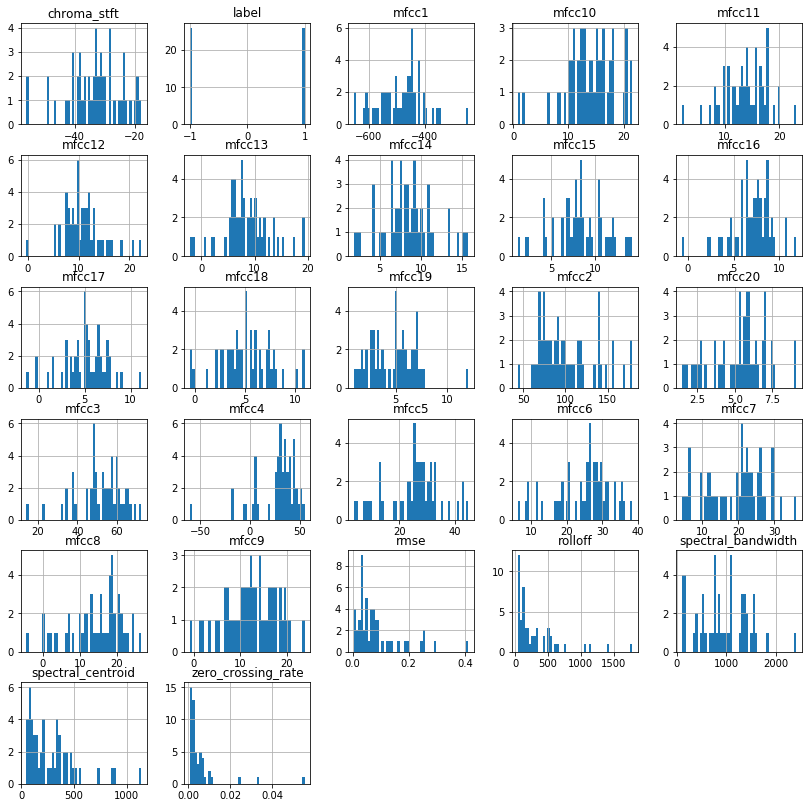

In [ ]:
data.hist(bins=50, figsize=(14,14))
plt.show()

In [ ]:
data.corr().style.background_gradient(cmap='RdYlGn')

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
chroma_stft,1,0.769644,-0.449722,-0.497114,-0.35637,-0.232169,0.850808,-0.471872,0.253285,0.258818,0.411928,0.156267,0.168986,0.181732,0.278797,0.17233,0.223253,0.332405,0.318389,0.135692,0.11379,-0.00849627,0.376959,-0.0394243,0.183764,-0.14542,-0.134523
rmse,0.769644,1,-0.339833,-0.334096,-0.307623,-0.242141,0.728309,-0.268133,0.238232,0.314918,0.307256,0.125947,0.137452,0.262232,0.272035,0.140856,0.00944034,0.164304,0.114329,0.0502886,-0.0698641,-0.00444758,0.252182,0.179424,0.215128,-0.0510553,-0.21553
spectral_centroid,-0.449722,-0.339833,1,0.872704,0.919322,0.78562,-0.139342,0.674739,-0.583392,-0.733969,-0.55886,-0.272842,-0.325433,-0.509061,-0.4743,-0.393257,-0.371276,-0.449446,-0.3535,-0.345994,-0.273562,-0.422664,-0.288276,-0.175067,-0.179204,0.248275,0.0445435
spectral_bandwidth,-0.497114,-0.334096,0.872704,1,0.630811,0.428015,-0.338895,0.467042,-0.42557,-0.478052,-0.338138,-0.0803663,-0.0708917,-0.204603,-0.279935,-0.376095,-0.406937,-0.533988,-0.38049,-0.408366,-0.289778,-0.233799,-0.148019,0.0487486,-0.0239157,0.373338,0.279629
rolloff,-0.35637,-0.307623,0.919322,0.630811,1,0.909729,0.0199513,0.751218,-0.615832,-0.839134,-0.637118,-0.324357,-0.434661,-0.676141,-0.540258,-0.295749,-0.247307,-0.383895,-0.361848,-0.266094,-0.148215,-0.474682,-0.363114,-0.340928,-0.249085,0.135379,-0.102067
zero_crossing_rate,-0.232169,-0.242141,0.78562,0.428015,0.909729,1,0.116532,0.649882,-0.574242,-0.782957,-0.529465,-0.282479,-0.388512,-0.596434,-0.50574,-0.343515,-0.324298,-0.239195,-0.231665,-0.214852,-0.241109,-0.525281,-0.280168,-0.355751,-0.21206,0.101254,-0.206371
mfcc1,0.850808,0.728309,-0.139342,-0.338895,0.0199513,0.116532,1,-0.0435992,0.0321634,-0.0577018,0.0481652,-0.0854007,-0.181947,-0.207984,-0.0530081,0.0840437,0.168495,0.255297,0.138026,0.0950888,0.0634834,-0.163006,0.0679034,-0.258965,-0.0592955,-0.240625,-0.194316
mfcc2,-0.471872,-0.268133,0.674739,0.467042,0.751218,0.649882,-0.0435992,1,-0.520692,-0.758519,-0.787128,-0.244471,-0.436295,-0.665427,-0.69676,-0.240469,-0.193347,-0.451118,-0.629903,-0.321561,-0.148313,-0.243165,-0.616637,-0.301524,-0.325404,0.0508952,-0.0250658
mfcc3,0.253285,0.238232,-0.583392,-0.42557,-0.615832,-0.574242,0.0321634,-0.520692,1,0.729841,0.45041,-0.170133,0.0322957,0.363095,0.469558,0.233163,0.176088,0.388968,0.417215,0.218955,-0.0319986,0.0327919,0.106768,-0.1201,-0.0921768,-0.303258,-0.139006
mfcc4,0.258818,0.314918,-0.733969,-0.478052,-0.839134,-0.782957,-0.0577018,-0.758519,0.729841,1,0.706797,0.0986895,0.233429,0.65245,0.57582,0.21706,0.106706,0.417143,0.427431,0.186458,-0.0553181,0.254732,0.28998,0.257233,0.0513425,-0.237595,-0.0613004


# Aplicando modelo de aprendizado

### Passo 01: Fazer preprocessamento dos dados

In [ ]:
# Retirar colunas desnecessárias
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,-17.938953,0.412915,433.436041,1348.680562,352.475053,0.005968,-243.142066,135.449303,61.997014,45.659463,22.972295,18.716659,9.678623,10.696918,7.425557,10.237305,7.522652,9.883407,6.117369,7.523315,4.129134,5.851761,3.073761,4.703141,2.076042,3.625250,-1
1,-31.814646,0.051774,883.186376,2413.645032,1062.383792,0.010107,-498.754147,76.143643,55.564120,3.099266,32.182653,20.346869,25.803801,8.482742,18.637764,14.141950,17.027479,8.632240,14.284937,9.528540,13.600491,3.499131,11.125027,2.594493,6.537717,6.330375,1
2,-24.140705,0.068945,75.985290,126.943706,131.833600,0.003876,-445.896263,70.209540,55.678279,39.060750,25.730073,17.312751,12.911670,11.465329,12.423868,14.908526,17.343015,18.297556,17.372483,15.044855,11.924791,8.462330,5.209411,2.890813,1.966197,2.251578,-1
3,-20.222477,0.242368,348.533169,1073.041974,429.390056,0.004606,-347.488180,103.701610,61.265503,40.421146,30.945685,20.517219,16.892888,17.903932,14.436799,11.056963,12.066593,11.490982,7.774761,6.456328,6.848995,5.435458,4.109769,4.120025,3.290146,2.697908,-1
4,-28.213728,0.064149,109.643262,159.708769,199.012679,0.005670,-416.029149,76.620055,60.133699,40.166350,22.970751,11.762580,6.750611,6.577388,9.345919,12.975202,15.642485,16.432506,15.495186,13.440842,10.687371,7.486051,4.361705,2.138256,1.353842,1.773721,-1


### Passo 02: Capturar variáveis de entrada e saída

As variáveis de entrada são todas as *features* que extraímos dos áudios e a variável de saída é o *label* que diz se um paciente é saudável (1) ou não (-1).

In [ ]:
X = data.values[:,:-1]
y = data['label'].values

In [ ]:
X[:2]

array([[-1.79389534e+01,  4.12915409e-01,  4.33436041e+02,
         1.34868056e+03,  3.52475053e+02,  5.96756725e-03,
        -2.43142066e+02,  1.35449303e+02,  6.19970140e+01,
         4.56594628e+01,  2.29722953e+01,  1.87166589e+01,
         9.67862258e+00,  1.06969185e+01,  7.42555700e+00,
         1.02373050e+01,  7.52265232e+00,  9.88340693e+00,
         6.11736928e+00,  7.52331471e+00,  4.12913399e+00,
         5.85176093e+00,  3.07376074e+00,  4.70314127e+00,
         2.07604167e+00,  3.62524987e+00],
       [-3.18146458e+01,  5.17737046e-02,  8.83186376e+02,
         2.41364503e+03,  1.06238379e+03,  1.01071953e-02,
        -4.98754147e+02,  7.61436426e+01,  5.55641196e+01,
         3.09926594e+00,  3.21826528e+01,  2.03468695e+01,
         2.58038014e+01,  8.48274182e+00,  1.86377639e+01,
         1.41419501e+01,  1.70274789e+01,  8.63224013e+00,
         1.42849366e+01,  9.52854040e+00,  1.36004909e+01,
         3.49913131e+00,  1.11250274e+01,  2.59449307e+00,
         6.53

In [ ]:
y[:2]

array([-1,  1])

### Passo 03: Separar conjunto de treino e de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

In [ ]:
X_train.shape, y_train.shape

((41, 26), (41,))

In [ ]:
X_test.shape, y_test.shape

((11, 26), (11,))

### Passo 04: Standardizar conjunto de dados

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Passo 05: Criar modelos de aprendizado

In [ ]:

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score


In [ ]:
models = {}
y_pred = {}
acc = {}

In [ ]:
models['gnb'] = GaussianNB()
models['svm'] = SVC(gamma='scale')
models['knn'] = KNeighborsClassifier(n_neighbors=3)
models['sgd'] = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

In [ ]:
for key in models:
  models[key].fit(X_train, y_train)
  y_pred[key] = models[key].predict(X_test)
  acc[key] = accuracy_score(y_test, y_pred[key])

In [ ]:
for key in acc:
  print("Modelo:{} | ACC:{}".format(key, acc[key]))

Modelo:gnb | ACC:0.9090909090909091
Modelo:svm | ACC:0.9090909090909091
Modelo:knn | ACC:0.8181818181818182
Modelo:sgd | ACC:0.7272727272727273


# Conclusões

### Dificuldades

Durante o desenvolvimento deste trabalho, eu tive algumas dificuldades. A primeira delas foi determinar o que exatamente eu utilizaria para treinar os modelos e fazer as classificações, uma vez que esse problema veio com várias tipos diferentes de conjuntos de dados. Ao longo do desenvolvimento do trabalho, observando exemplos de como outras pessoas fizeram, decidi utilizar apenas os arquivos de áudio como fonte de *features* e o arquivo de diagnósticos, como fonte de *labels*  e identificação dos pacientes. 

Outro problema que surgiu foi quais áudios utilizar. Fiquei na dúvida se utilizaria todos ou não. Observando a distribuição dos dados, vi que havia muito mais áudios de pacientes com problemas respiratórios do que com pacientes saudáveis. Em um primeiro momento, tentei utilizar os áudios mesmo com esse desbalanceamento. Mas, devido aos resultados não tão bons, resolvi selecionar uma mesma quantidade de áudios para pacientes saudáveis e não saudáveis. 

Um terceiro grande problema que surgiu foi que algoritmos de aprendizado empregar. A grande maioria dos exemplos que encontrei utilizava algum tipo de redes neurais. Então, tentei utilizá-las também. Entretanto, não obtive sucesso. Eu não consegui entender muito bem como configurar a rede que eu empreguei, então não obtive valores de acurácia muito bons. Dessa forma, decidi empregar alguns dos algoritmos que vimos em sala de aula, os quais apresentaram valores de acurácia bem melhores.



### Aprendizados

Acho que um dos maiores aprendizados que obtive é que existem diferentes maneiras de se fazer uma mesma coisa. No caso do problema que eu escolhi, existem diferentes maneiras de utilizar os conjuntos de dados que são fornecidos, para diferentes objetivos, o que pode conduzir diferentes níveis de resultados.

### Melhorias

Há muitas melhorias que podem ser feitas neste trabalho, que envolvem tanto um melhor processamento dos sinais de áudio - que possuem ruídos -, um melhor aproveitamento dos conjuntos de dados fornecidos, uma melhor escolha das *features* a serem utilizadas e o emprego de algoritmos de aprendizagem considerados melhores para esse tipo de problema, como, por exemplo, redes neurais.